# XGBoost HYPEROPT VS XGBoost VS SVR PRICE REGRESSION

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [16]:
df=pd.read_csv('audi.csv',skipinitialspace=True)

In [17]:
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0


I will reorder the columns to group the categorical variables first and then the numerical ones

In [18]:
df=df[['model','year','transmission','fuelType','mileage','tax','mpg','engineSize','price']]

In [19]:
df.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10668 entries, 0 to 10667
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         10668 non-null  object 
 1   year          10668 non-null  int64  
 2   transmission  10668 non-null  object 
 3   fuelType      10668 non-null  object 
 4   mileage       10668 non-null  int64  
 5   tax           10668 non-null  int64  
 6   mpg           10668 non-null  float64
 7   engineSize    10668 non-null  float64
 8   price         10668 non-null  int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 750.2+ KB


There are no missing values

In [21]:
#Convert year column to object so we can include it in the categorical mask
df['year']=df['year'].astype(object)

In [22]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == object)

In [23]:
categorical_columns = df.columns[categorical_mask].tolist()

In [24]:
print(df[categorical_columns].head())

  model  year transmission fuelType
0    A1  2017       Manual   Petrol
1    A6  2016    Automatic   Diesel
2    A1  2016       Manual   Petrol
3    A4  2017    Automatic   Diesel
4    A3  2019       Manual   Petrol


In [25]:
df[categorical_columns].describe()

,model,year,transmission,fuelType
count,10668,10668,10668,10668
unique,26,21,3,3
top,A3,2019,Manual,Diesel
freq,1929,3197,4369,5577


In [26]:
#COLUMN TRANSFORMER to get OH conded cols!
#This allows us to skip the label encoder and directly apply the one hot encoding!


#from sklearn.preprocessing import OneHotEncoder
#from sklearn.compose import ColumnTransformer
#ct = ColumnTransformer([(categorical_columns, OneHotEncoder(), [0])], remainder = 'passthrough')
#df[categorical_columns] = ct.fit_transform(df[categorical_columns])

In [27]:
#Use get dummies instead of one hot encoding, 

#Create a copy of the DF where we substitue the categorical column into more cols with dummies
encoded_df=df.copy()
encoded_df = pd.concat([df.drop(categorical_columns, axis=1), pd.get_dummies(df[categorical_columns], drop_first=True)], axis=1)

## One Hot encoding

In [28]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='error')
enc.fit(df[categorical_columns])

OneHotEncoder()

In [29]:
df[categorical_columns]

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol
1,A6,2016,Automatic,Diesel
2,A1,2016,Manual,Petrol
3,A4,2017,Automatic,Diesel
4,A3,2019,Manual,Petrol
...,...,...,...,...
10663,A3,2020,Manual,Petrol
10664,A3,2020,Manual,Petrol
10665,A3,2020,Manual,Petrol
10666,Q3,2017,Automatic,Petrol


In [30]:
import joblib
joblib.dump(enc, 'encoder.joblib')

['encoder.joblib']

In [31]:
df_encode = df[categorical_columns]
df_encode = pd.DataFrame(data=enc.transform(df_encode).toarray(),columns=enc.get_feature_names(categorical_columns), dtype=bool)
# trasfer true and false to 1 and 0
df_encode = df_encode * 1

# concatenate data
df_OHE = pd.concat((df.drop(categorical_columns, axis=1), df_encode), axis=1)
df_OHE.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


In [32]:
encoded_df=df_OHE
encoded_df.head()

,mileage,tax,mpg,engineSize,price,model_A1,model_A2,model_A3,model_A4,model_A5,...,year_2017,year_2018,year_2019,year_2020,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol
0,15735,150,55.4,1.4,12500,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
1,36203,20,64.2,2.0,16500,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,29946,30,55.4,1.4,11000,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,25952,145,67.3,2.0,16800,0,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0
4,1998,145,49.6,1.0,17300,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,1


I have 58 columns: 5 (numeric_cols) + 53 (unique cateogric_cols) = 58

Now the data is ready for the learning

### Prepare the data for learning

In [33]:
X=encoded_df.drop('price', axis = 1).values

In [34]:
y=encoded_df['price'].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [36]:
scaler = StandardScaler()

In [37]:
scaler.fit(X_train)

StandardScaler()

In [38]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

## Support Vector Regression

In [91]:
from sklearn.svm import SVR

In [92]:
param_SVM = {'C':np.arange(500,5000,50),
            'gamma':np.arange(0.001, 0.8, 0.01)}

In [93]:
svr_model=SVR()

In [94]:
cv_SVM = RandomizedSearchCV(estimator=svr_model, param_distributions = param_SVM, n_iter=10, cv = 5)

In [95]:
cv_SVM.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions={'C': array([ 500,  550,  600,  650,  700,  750,  800,  850,  900,  950, 1000,
       1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550,
       1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100,
       2150, 2200, 2250, 2300, 2350, 2400, 2450, 2500, 2550, 2600, 2650,
       2700, 2750, 2800, 2850, 2900, 2950, 3000, 3050, 3100, 3150, 3200,
       3250, 3300, 335...
       0.181, 0.191, 0.201, 0.211, 0.221, 0.231, 0.241, 0.251, 0.261,
       0.271, 0.281, 0.291, 0.301, 0.311, 0.321, 0.331, 0.341, 0.351,
       0.361, 0.371, 0.381, 0.391, 0.401, 0.411, 0.421, 0.431, 0.441,
       0.451, 0.461, 0.471, 0.481, 0.491, 0.501, 0.511, 0.521, 0.531,
       0.541, 0.551, 0.561, 0.571, 0.581, 0.591, 0.601, 0.611, 0.621,
       0.631, 0.641, 0.651, 0.661, 0.671, 0.681, 0.691, 0.701, 0.711,
       0.721, 0.731, 0.741, 0.751, 0.761, 0.771, 0.781, 0.791])})

In [96]:
y_pred_SVM = cv_SVM.predict(X_test)

In [97]:
# Compute and print the metrics
print("Tuned SVM parameters: {}".format(cv_SVM.best_params_))

Tuned SVM parameters: {'gamma': 0.09099999999999998, 'C': 2300}


In [98]:
mse_SVM = mean_squared_error(y_test, y_pred_SVM)
print("RMSE using SVM: ", np.sqrt(mse_SVM))

RMSE using SVM:  5507.927257348135


## XGBoost

In [51]:
import xgboost as xgb

In [52]:
# Create the parameter grid
param_grid = {
    'learning_rate': np.arange(0.01, 0.5, 0.01),
    'max_depth': np.arange(3, 30, 2),
    'n_estimators': np.arange(50, 200, 15)
}

In [57]:
xgb_model=xgb.XGBRegressor(verbosity = 0)

In [58]:
rand_neg_mse = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=3)

In [59]:
rand_neg_mse.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=XGBRegressor(verbosity=0),
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49]),
                                        'max_depth': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                                        'n_estimators': array([ 50,  65,  80,  95, 110, 125, 140, 155, 170, 185])},
                   scoring='neg_mean_squared_error')

In [60]:
print("Best rmse:", np.sqrt(np.abs(rand_neg_mse.best_score_)))

Best rmse: 2674.113330149853


In [61]:
print("Best model: ", rand_neg_mse.best_estimator_)

Best model:  XGBRegressor(learning_rate=0.38, n_estimators=140, verbosity=0)


In [62]:
y_pred_RND = rand_neg_mse.predict(X_test)

In [63]:
# Compute and print the metrics
print("Tuned XGB parameters by RandomizedGridSearch: {}".format(rand_neg_mse.best_params_))

Tuned XGB parameters by RandomizedGridSearch: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.38}


## XGBoost with Hyperopt by Baesian method

In [64]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [65]:
space={'max_depth': hp.choice("max_depth", np.arange(3, 18, 1)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'learning_rate': hp.quniform("learning_rate", 0.0001, 0.5, 0.01),
      }

In [66]:
def hyperparameter_tuning(space):
    print(space)
    model = xgb.XGBRegressor(max_depth =space['max_depth'],
                           min_child_weight=space['min_child_weight'],
                           gamma = space['gamma'],
                           reg_alpha = space['reg_alpha'],
                           reg_lambda = space['reg_lambda'],
                            learning_rate=space['learning_rate'])

    eval_set  = [( X_train, y_train), ( X_test, y_test)]

    model.fit(X_train, y_train,
            eval_set=eval_set, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(X_test)
    mse_scr = mean_squared_error(y_test, pred)
    print("SCORE:", np.sqrt(mse_scr))
    #change the metric if you like
    return {'loss':mse_scr, 'status': STATUS_OK }

In [67]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print (best)

{'gamma': 7.166306442844341, 'learning_rate': 0.15, 'max_depth': 17, 'min_child_weight': 7.0, 'reg_alpha': 95.0, 'reg_lambda': 0.9236628181631265}
[17:58:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                                                 
2430.1472119487894                                                                                                     
{'gamma': 7.141160412354292, 'learning_rate': 0.06, 'max_depth': 12, 'min_child_weight': 2.0, 'reg_alpha': 145.0, 'reg_lambda': 0.5372502737886806}
[17:58:29] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                                                 
2369.183467759729

2424.515180534912                                                                                                      
{'gamma': 7.263979740843749, 'learning_rate': 0.49, 'max_depth': 11, 'min_child_weight': 5.0, 'reg_alpha': 173.0, 'reg_lambda': 0.01357186870425664}
[17:59:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                                                 
2607.6369449888734                                                                                                     
{'gamma': 2.082320233174748, 'learning_rate': 0.14, 'max_depth': 9, 'min_child_weight': 4.0, 'reg_alpha': 162.0, 'reg_lambda': 0.8645167648974597}
[17:59:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:          

SCORE:                                                                                                                 
2359.876193314889                                                                                                      
{'gamma': 5.3380924946103105, 'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 3.0, 'reg_alpha': 114.0, 'reg_lambda': 0.07623641320542723}
[18:00:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                                                 
2404.9374005104496                                                                                                     
{'gamma': 3.867674822269712, 'learning_rate': 0.18, 'max_depth': 16, 'min_child_weight': 3.0, 'reg_alpha': 93.0, 'reg_lambda': 0.5949681383006138}
[18:00:09] WARNING: C:/Jenkins/workspace/xgboost-win64_relea

[18:00:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                                                 
2441.7978572405063                                                                                                     
{'gamma': 1.8662609137453112, 'learning_rate': 0.16, 'max_depth': 7, 'min_child_weight': 8.0, 'reg_alpha': 67.0, 'reg_lambda': 0.44949335091553516}
[18:00:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
SCORE:                                                                                                                 
2391.729759577479                                                                                                      
{'gamma': 7.1888197408765, 'learning_rate': 

In [68]:
print("The best hyperparameters are : ","\n")
print(best)

The best hyperparameters are :  

{'gamma': 2.583547505770185, 'learning_rate': 0.23, 'max_depth': 8, 'min_child_weight': 6.0, 'reg_alpha': 116.0, 'reg_lambda': 0.38414700478762503}


In [69]:
xgb_opt = xgb.XGBRegressor(max_depth = best['max_depth'],
                       gamma = best['gamma'],
                       reg_lambda = best['reg_lambda'],
                       reg_alpha = best['reg_alpha'],
                       min_child_weight = best['min_child_weight'],
                          learning_rate=best['learning_rate'],)

In [70]:
xgb_opt.fit(X_train, y_train)

[18:01:10] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(gamma=2.583547505770185, learning_rate=0.23, max_depth=8,
             min_child_weight=6.0, reg_alpha=116.0,
             reg_lambda=0.38414700478762503)

In [71]:
# Predicting the Test set results
y_pred_XGB_OPT = xgb_opt.predict(X_test)

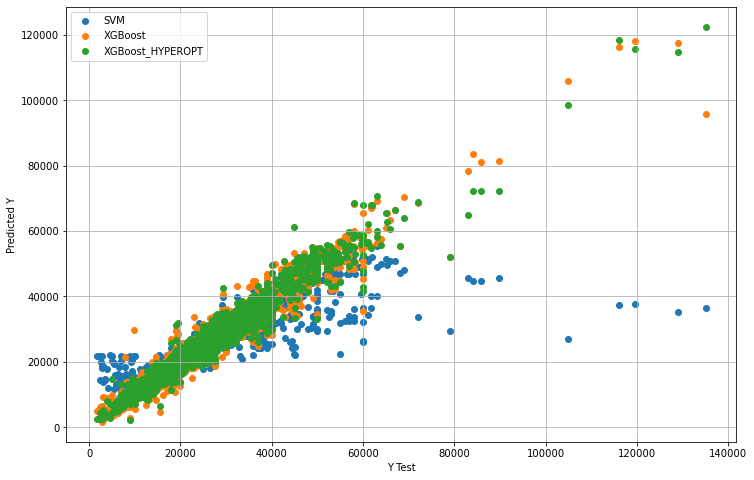

In [99]:
plt.figure(figsize = (12,8))

plt.scatter(y_test, y_pred_SVM, label='SVM')
plt.scatter(y_test, y_pred_RND, label='XGBoost')
plt.scatter(y_test, y_pred_XGB_OPT, label='XGBoost_HYPEROPT')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.legend(loc='upper left');
plt.grid()

In [100]:
mse_XGB_OPT = mean_squared_error(y_test, y_pred_XGB_OPT)
print("RMSE using SVM: ", np.sqrt(mse_SVM))
print("RMSE using XGBoost: ", np.sqrt(np.abs(rand_neg_mse.best_score_)))
print("RMSE using XGBoost_HYPEROPT: ", np.sqrt(mse_XGB_OPT))

RMSE using SVM:  5507.927257348135
RMSE using XGBoost:  2674.113330149853
RMSE using XGBoost_HYPEROPT:  2352.9995921167215


We get better results with XGBoost and we can even improve the RMSE with the Baesian optimization

In [101]:
import pickle

In [102]:
pickle.dump(xgb_opt, open('model.pkl','wb'))

In [103]:
pickle.dump(scaler, open('scaler.pkl','wb'))

# DEBUG FOR ML DEPLYMENT

In [104]:
df.head()

,model,year,transmission,fuelType,mileage,tax,mpg,engineSize,price
0,A1,2017,Manual,Petrol,15735,150,55.4,1.4,12500
1,A6,2016,Automatic,Diesel,36203,20,64.2,2.0,16500
2,A1,2016,Manual,Petrol,29946,30,55.4,1.4,11000
3,A4,2017,Automatic,Diesel,25952,145,67.3,2.0,16800
4,A3,2019,Manual,Petrol,1998,145,49.6,1.0,17300


In [105]:
feat=['A1','2017','Manual','Petrol','15735','150']

In [106]:
num_feat = np.append(feat[4:6],[55.4,1.4])
num_feat

array(['15735', '150', '55.4', '1.4'], dtype='<U32')

In [117]:
df_cat=pd.DataFrame([feat[0:4]], columns=['model','year','transmission','fuelType'])
df_cat

,model,year,transmission,fuelType
0,A1,2017,Manual,Petrol


In [124]:
df_cat.year=int(df_cat.year)

In [125]:
cat_feat = enc.transform(df_cat).toarray()

In [126]:
enc_feat = np.append(num_feat, cat_feat)

In [127]:
scaled_feat=scaler.transform(enc_feat.reshape(1,-1))

In [128]:
prediction = xgb_opt.predict(scaled_feat)[0]
prediction

14063.334